In [1]:
import scipy.signal as sig
import skimage as sk
import skimage.io as skio
import cv2
import matplotlib.pyplot as plt
import math
import numpy as np
import skimage.transform as sktr

In [2]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

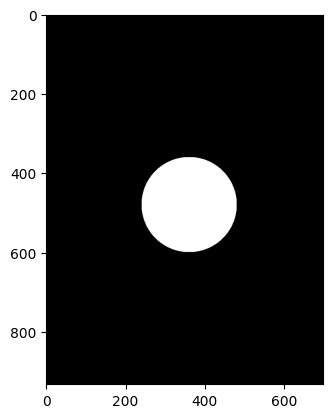

In [62]:
mask = create_circular_mask(im1.shape[0], im1.shape[1], (360, 480), 120)
plt.imshow(mask, cmap='grey')

In [75]:
def getStacksMasked(im1, boundary):
    gaussian = cv2.getGaussianKernel(30, 60)
    gaussian = gaussian * gaussian.T

    # mask = np.zeros_like(im1[:,:,0])
    # mask[:, boundary:] = 1
    mask = create_circular_mask(im1.shape[0], im1.shape[1], (360, 480), 100)

    gaussianStackR = [im1[:,:,0]/np.max(im1[:,:,0])]
    gaussianStackG = [im1[:,:,1]/np.max(im1[:,:,1])]
    gaussianStackB = [im1[:,:,2]/np.max(im1[:,:,2])]
    gaussianFilters = [mask]

    gaussianStackRGB = [gaussianStackR, gaussianStackG, gaussianStackB]
    for a in range(0, 15):
        print(f'loop: {a}')
        gaussianFilters.append(sig.convolve2d(gaussianFilters[-1], gaussian, mode="same", boundary='symm'))
        for i in range(0, 3):
            # temp = np.clip(sig.convolve2d(gaussianStackRGB[i][-1], gaussian, mode="same", boundary='symm'), 0, None)
            # gaussianStackRGB[i].append(temp/np.max(temp))
            gaussianStackRGB[i].append(sig.convolve2d(gaussianStackRGB[i][-1], gaussian, mode="same", boundary='symm'))

    laplaceStackR = []
    laplaceStackG = []
    laplaceStackB = []

    laplaceStackRGB = [laplaceStackR, laplaceStackG, laplaceStackB]
    for i in range(0, 3):
        for b in range(15, 0, -1):
            # temp = np.clip(gaussianStackRGB[i][b] - gaussianStackRGB[i][b-1], 0, None)
            # laplaceStackRGB[i].append(temp/np.max(temp))
            # print((gaussianStackRGB[i][b] - gaussianStackRGB[i][b-1]).shape)
            laplaceStackRGB[i].append(gaussianStackRGB[i][b-1] - gaussianStackRGB[i][b])
        laplaceStackRGB[i] = list(reversed(laplaceStackRGB[i]))
    return gaussianFilters, gaussianStackRGB, laplaceStackRGB

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
loop: 7
loop: 8
loop: 9
loop: 10
loop: 11
loop: 12
loop: 13
loop: 14


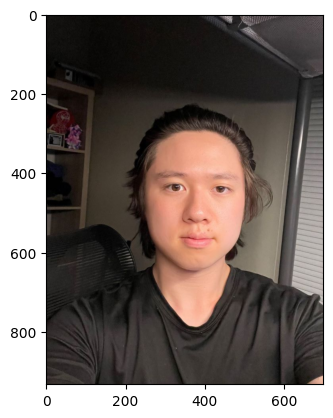

In [76]:
im1 = cv2.imread("./images/me.jpg")
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

orangeFilters, orangeGaussian, orangeLaplace = getStacksMasked(im1, 150)
plt.imshow(im1, cmap='grey')

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
loop: 7
loop: 8
loop: 9
loop: 10
loop: 11
loop: 12
loop: 13
loop: 14


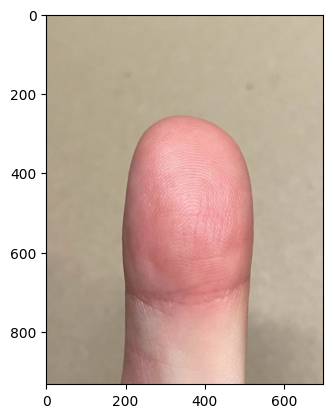

In [77]:
im2 = cv2.imread("./images/thumb.jpg")
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
im2 = im2[:933, :]
appleFilters, appleGaussian, appleLaplace = getStacksMasked(im2, 120)
plt.imshow(im2, cmap='grey')

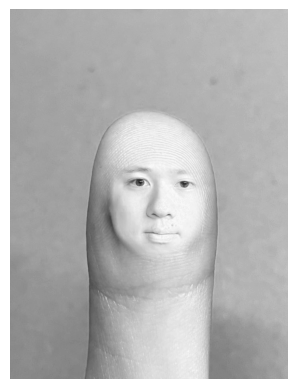

In [80]:
redBase = appleGaussian[0][-1] * (1-appleFilters[-1]) + orangeGaussian[0][-1] * (appleFilters[-1])
# redBase = appleFilters[-1]
for i in range(1, 16): #7
   redBase += appleLaplace[0][-i] * (1-appleFilters[-i]) + orangeLaplace[0][-i] * (appleFilters[-i])
redBase = redBase + np.min(redBase)
redBase = redBase/np.max(redBase)
plt.axis('off')
plt.imshow(redBase, cmap="grey")

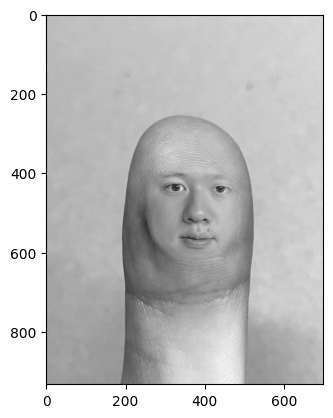

In [81]:
greenBase = appleGaussian[1][-1] * (1-appleFilters[-1]) + orangeGaussian[1][-1] * (appleFilters[-1])
for i in range(1, 16): #7
   greenBase += appleLaplace[1][-i] * (1-appleFilters[-i]) + orangeLaplace[1][-i] * (appleFilters[-i])
greenBase = greenBase + np.min(greenBase)
greenBase = greenBase/np.max(greenBase)
plt.imshow(greenBase, cmap="grey")

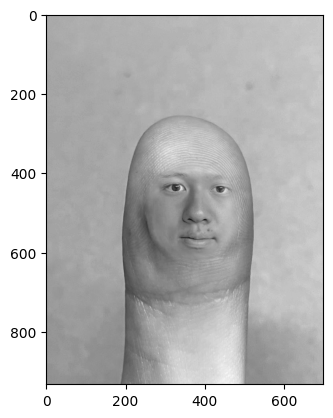

In [82]:
blueBase = appleGaussian[2][-1] * (1-appleFilters[-1]) + orangeGaussian[2][-1] * (appleFilters[-1])
# blueBase = orangeGaussian[2][0]
for i in range(1, 16): #7
   blueBase += appleLaplace[2][-i] * (1-appleFilters[-i]) + orangeLaplace[2][-i] * (appleFilters[-i])
blueBase = blueBase + np.min(blueBase)
blueBase = blueBase / np.max(blueBase)
plt.imshow(blueBase, cmap="grey")

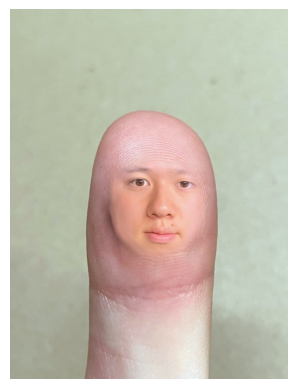

In [83]:
plt.axis('off')
plt.imshow(np.stack((redBase, greenBase, blueBase), axis=2))
# plt.savefig('./webImages/part2.4/orapleRemadeColored.jpg', bbox_inches='tight', pad_inches=0)